 55%|█████▌    | 22162/40000 [04:24<03:33, 83.65it/s] 


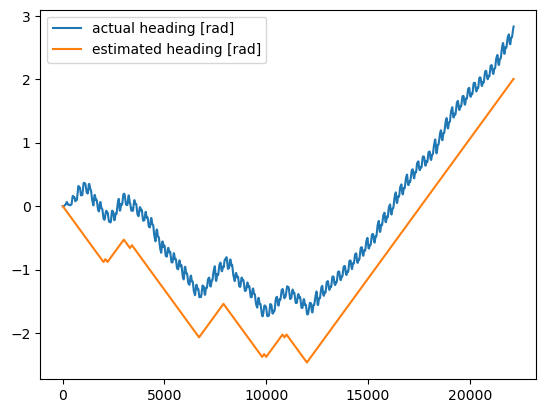

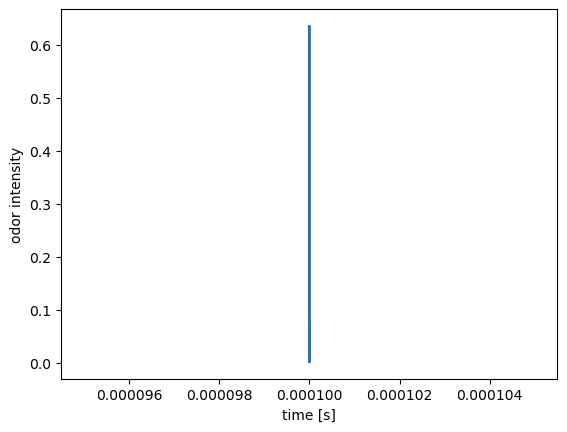

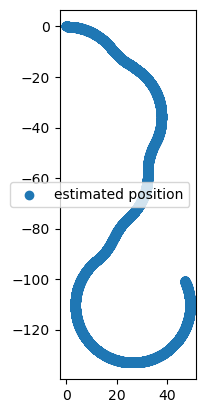

In [ ]:
from pathlib import Path
from submission import Controller
from cobar_miniproject.cobar_fly import CobarFly
from cobar_miniproject import levels
from flygym import SingleFlySimulation, Camera
from tqdm import trange
import matplotlib.pyplot as plt
import numpy as np
import time as time

timestep = 1e-4
debug = False
level = 4
seed = 35

fly = CobarFly(
    debug=debug,
    enable_vision=True,
    render_raw_vision=True,
)

if level <= 1:
    arena = levels[level](fly=fly, seed=seed)
else:
    arena = levels[level](fly=fly, timestep=timestep, seed=seed)

cam_params = {"pos": (0, 0, 80)}
timestep = 1e-4

cam = Camera(
    attachment_point=arena.root_element.worldbody,
    camera_name="camera_top_zoomout",
    targeted_fly_names=[fly.name],
    camera_parameters=cam_params,
    play_speed=0.2,
)

sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
    timestep=timestep,
    arena=arena,
)

controller = Controller(timestep=timestep)

# run cpg simulation
obs, info = sim.reset()
obs_hist = []
info_hist = []
calc_heading = []
est_pos = []
odor = []
times = []

max_steps = 40000
for i in trange(max_steps):
    # Get observations
    act = controller.get_actions(obs)
    calc_heading.append(act["heading"])
    est_pos.append(act["pos"])
    obs, reward, terminated, truncated, info = sim.step(act)
    sim.render()
    if controller.done_level(obs):
        # finish the path integration level
        break


    """if "vision" in obs:
        del obs["vision"]
    if "raw_vision" in obs:
        del obs["raw_vision"]"""
    obs_hist.append(obs["heading"])
    times.append(timestep)
    odor.append(obs["odor_intensity"][0][0])
    #info_hist.append(info)
    if hasattr(controller, "quit") and controller.quit:
        print("Simulation terminated by user.")
        break
    if hasattr(arena, "quit") and arena.quit:
        print("Target reached. Simulation terminated.")
        break

plt.plot(obs_hist, label="actual heading [rad]")
plt.plot(calc_heading, label="estimated heading [rad]")
plt.legend()
plt.show()

odor = np.array(odor)
plt.plot(times, odor)
plt.xlabel("time [s]")
plt.ylabel("odor intensity")
plt.show()

est_pos = np.array(est_pos)
plt.scatter(est_pos[:, 0], est_pos[:, 1], label="estimated position")
plt.gca().set_aspect("equal")
plt.legend()


# Save video
save_path = Path("outputs") / f"level{level}_seed{seed}.mp4"
save_path.parent.mkdir(parents=True, exist_ok=True)
cam.save_video(save_path, stabilization_time=0)